# Importing Modules 

In [113]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time 

# Load the Images 

In [114]:
content_path= "/home/mrinita1024/cloudxlab_jupyter_notebooks/AS.jpg"
style_path="/home/mrinita1024/cloudxlab_jupyter_notebooks/picasso.jpg"

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]

    return img

In [115]:
content_image = load_img(content_path)
style_image = load_img(style_path)

# Visualizing the Images 

In [116]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

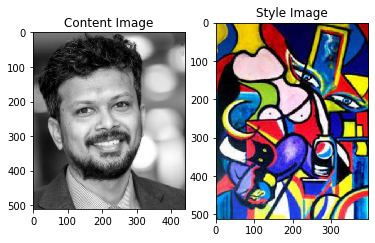

In [117]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [118]:
print("Content image shape: ",content_image.shape)
print("Style image shape: ",style_image.shape)

Content image shape:  (1, 512, 441, 3)
Style image shape:  (1, 512, 397, 3)


# Loading Pre-trained VGG19 

In [119]:
x=tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

# Instantiating the VGG19 model 
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [120]:
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

(1, 1000)


In [121]:
# Printing the top 5 predicted classes

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions( prediction_probabilities.numpy() )[0]

print([(class_name, prob) for (number, class_name, prob) in predicted_top_5])

[('bow_tie', 0.49883163), ('suit', 0.2677075), ('Windsor_tie', 0.045110743), ('military_uniform', 0.027501557), ('oboe', 0.018883679)]


In [122]:
# Loading the VGG19 network without the classification head

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_11
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [123]:
# Choosing intermediate layers from the network to represent 
# the style and content of the image

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        'block4_conv1', 
        'block5_conv1']

# Getting model with the specified VGG19 Layers

In [124]:
def vgg_layers(layer_names):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [125]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_outputs = style_extractor(style_image*255)

In [126]:
# Statistics of each input layer

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


block1_conv1
  shape:  (1, 512, 397, 64)
  min:  0.0
  max:  870.8682
  mean:  36.95723

block2_conv1
  shape:  (1, 256, 198, 128)
  min:  0.0
  max:  5122.1797
  mean:  197.89882

block3_conv1
  shape:  (1, 128, 99, 256)
  min:  0.0
  max:  12573.896
  mean:  255.14139

block4_conv1
  shape:  (1, 64, 49, 512)
  min:  0.0
  max:  26299.05
  mean:  812.9575

block5_conv1
  shape:  (1, 32, 24, 512)
  min:  0.0
  max:  3771.2368
  mean:  69.401726



# Calculating Style 

In [127]:
def gram_matrix(input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result/(num_locations)

# Extracting style and content - 1 

In [128]:
# Defining the StyleContentModel, which returns the style 
# and content representations of the given input image

class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                              outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)  
                            for style_output in style_outputs]
        content_dict = {content_name:value 
            for content_name, value 
            in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
          for style_name, value
          in zip(self.style_layers, style_outputs)}    
        return {'content':content_dict, 'style':style_dict}

# Extracting style and content - 2 

In [129]:
# Instantiating the class StyleContentModel

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [130]:
# Statistics of the gram-matrices returned for the content 
# image

for name, output in sorted(results['style'].items()):
      print("  ", name)
      print("    shape: ", output.numpy().shape)
      print("    min: ", output.numpy().min())
      print("    max: ", output.numpy().max())
      print("    mean: ", output.numpy().mean())
      print()

   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  34307.684
    mean:  272.12332

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  41885.31
    mean:  7780.6807

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  223811.02
    mean:  6833.8867

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2800348.5
    mean:  125199.49

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  113290.43
    mean:  945.87415



In [131]:
# Statistics of the content matrices returned for the 
# content image

for name, output in sorted(results['content'].items()):
       print("  ", name)
       print("    shape: ", output.numpy().shape)
       print("    min: ", output.numpy().min())
       print("    max: ", output.numpy().max())
       print("    mean: ", output.numpy().mean())

   block5_conv2
    shape:  (1, 32, 27, 512)
    min:  0.0
    max:  1164.6913
    mean:  12.61181


# Getting the Target Content and Style 

In [132]:
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']

# Defining some Hyper-parameters 

In [133]:
style_weight=1e-2
content_weight=1e4

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

image = tf.Variable(content_image)

# Defining Loss Function 

In [134]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(
                                (style_outputs[name] - style_targets[name])**2) 
                                for name in style_outputs.keys()] )
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean(
                                (content_outputs[name]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Converting Tensor to Image 

In [135]:
# Defining a function tensor_to_image to convert the input 
# tensor to an image format

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor) #converting the tensor to image

# Define the Training Step

In [136]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

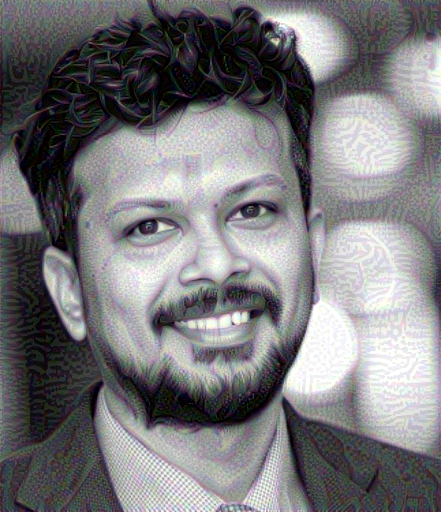

In [137]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

# Optimization 

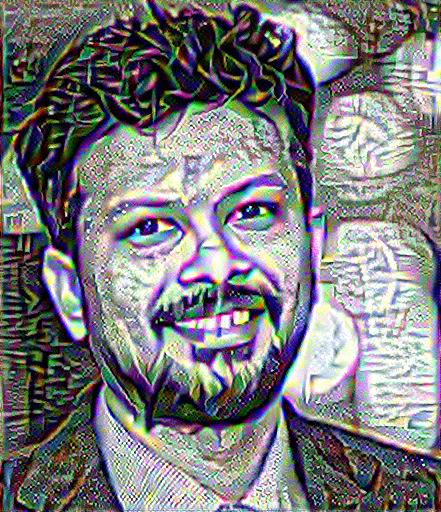

Train step: 50
Total time: 168.0


In [138]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))